In [48]:
import sys

sys.path.append("../")
import pandas as pd
from config.settings import MONGO_CONNECTION_STRING
from datetime import datetime, timedelta
from src.indicators.sma import calculate_sma
from pymongo import MongoClient
import json

In [11]:
client = MongoClient(
    MONGO_CONNECTION_STRING,
    tls=True,
    tlsAllowInvalidCertificates=True,  # For development only
    # tlsCAFile='/Users/tyrelle/Desktop/4ex.ninja/4ex.ninja/config/global-bundle.pem'
)

In [20]:
db = client["forex_data"]
collections = db.list_collection_names()


In [23]:
collections

['EUR_USD_H1',
 'EUR_USD_H4',
 'GBP_USD_H4',
 'EUR_GBP_D',
 'USD_JPY_H1',
 'AUD_USD_H4',
 'GBP_USD_D',
 'USD_CAD_H1',
 'USD_CAD_D',
 'USD_CAD_H4',
 'NZD_USD_H1',
 'EUR_GBP_H1',
 'AUD_USD_D',
 'EUR_USD_D',
 'NZD_USD_D',
 'GBP_JPY_D',
 'GBP_USD_H1',
 'NZD_USD_H4',
 'EUR_GBP_H4',
 'EUR_USD_M15',
 'USD_JPY_D',
 'GBP_JPY_H1',
 'GBP_JPY_H4',
 'USD_JPY_H4',
 'AUD_USD_H1']

In [29]:
# Choose a collection (for example EUR_USD_H4)
collection_name = "EUR_USD_H4"
collection = db[collection_name]

# Fetch all documents and convert to DataFrame
df_EURUSD_H4 = pd.DataFrame(list(collection.find()))

# Set the time column as the index
df_EURUSD_H4.set_index("time", inplace=True)

# Extract OHLC values from the mid dictionary
df_EURUSD_H4["open"] = df_EURUSD_H4["mid"].apply(lambda x: float(x["o"]))
df_EURUSD_H4["high"] = df_EURUSD_H4["mid"].apply(lambda x: float(x["h"]))
df_EURUSD_H4["low"] = df_EURUSD_H4["mid"].apply(lambda x: float(x["l"]))
df_EURUSD_H4["close"] = df_EURUSD_H4["mid"].apply(lambda x: float(x["c"]))

# Drop unnecessary columns and reorder
df_EURUSD_H4 = df_EURUSD_H4[["volume", "open", "high", "low", "close"]]

# Display information about the data
print(f"\nDataFrame info for {collection_name}:")
print(f"Total number of candles: {len(df_EURUSD_H4)}")
print("\nFirst few rows:")
print(df_EURUSD_H4.head())


DataFrame info for EUR_USD_H4:
Total number of candles: 15547

First few rows:
                     volume     open     high      low    close
time                                                           
2015-02-15 22:00:00    3193  1.13999  1.14120  1.13893  1.14086
2015-02-16 02:00:00    1412  1.14082  1.14226  1.14030  1.14144
2015-02-16 06:00:00    3400  1.14144  1.14291  1.13955  1.14034
2015-02-16 10:00:00    2865  1.14030  1.14203  1.13969  1.14064
2015-02-16 14:00:00    4829  1.14066  1.14150  1.13408  1.13564


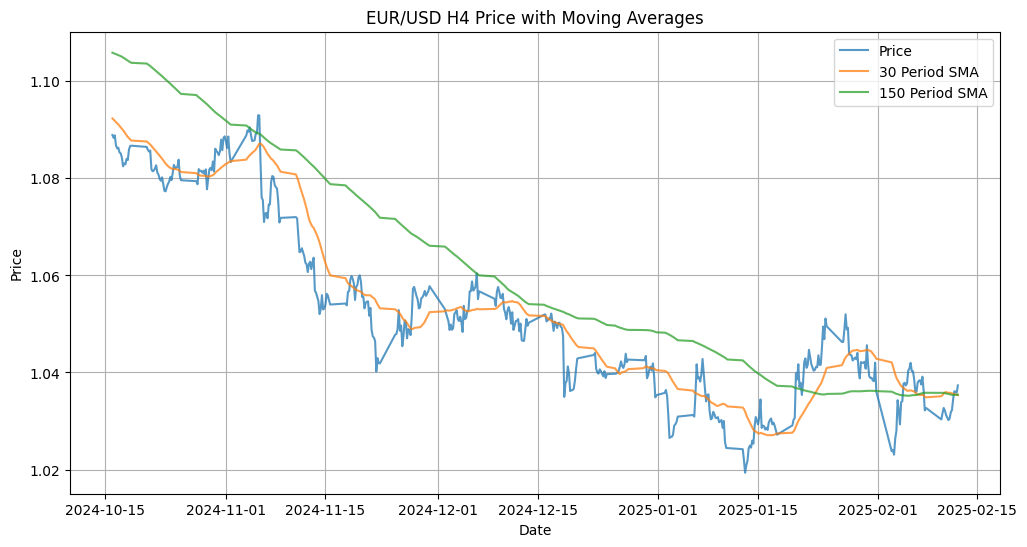

In [49]:
# Calculate moving averages
df_EURUSD_H4["SMA_30"] = calculate_sma(df_EURUSD_H4["close"], [30])[
    "sma_30"
]  # Pass period as a list
df_EURUSD_H4["SMA_150"] = calculate_sma(df_EURUSD_H4["close"], [150])[
    "sma_150"
]  # Pass period as a list

# Import plotting library
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(
    df_EURUSD_H4.index[-500:], df_EURUSD_H4["close"][-500:], label="Price", alpha=0.75
)
plt.plot(
    df_EURUSD_H4.index[-500:],
    df_EURUSD_H4["SMA_30"][-500:],
    label="30 Period SMA",
    alpha=0.75,
)
plt.plot(
    df_EURUSD_H4.index[-500:],
    df_EURUSD_H4["SMA_150"][-500:],
    label="150 Period SMA",
    alpha=0.75,
)

plt.title("EUR/USD H4 Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

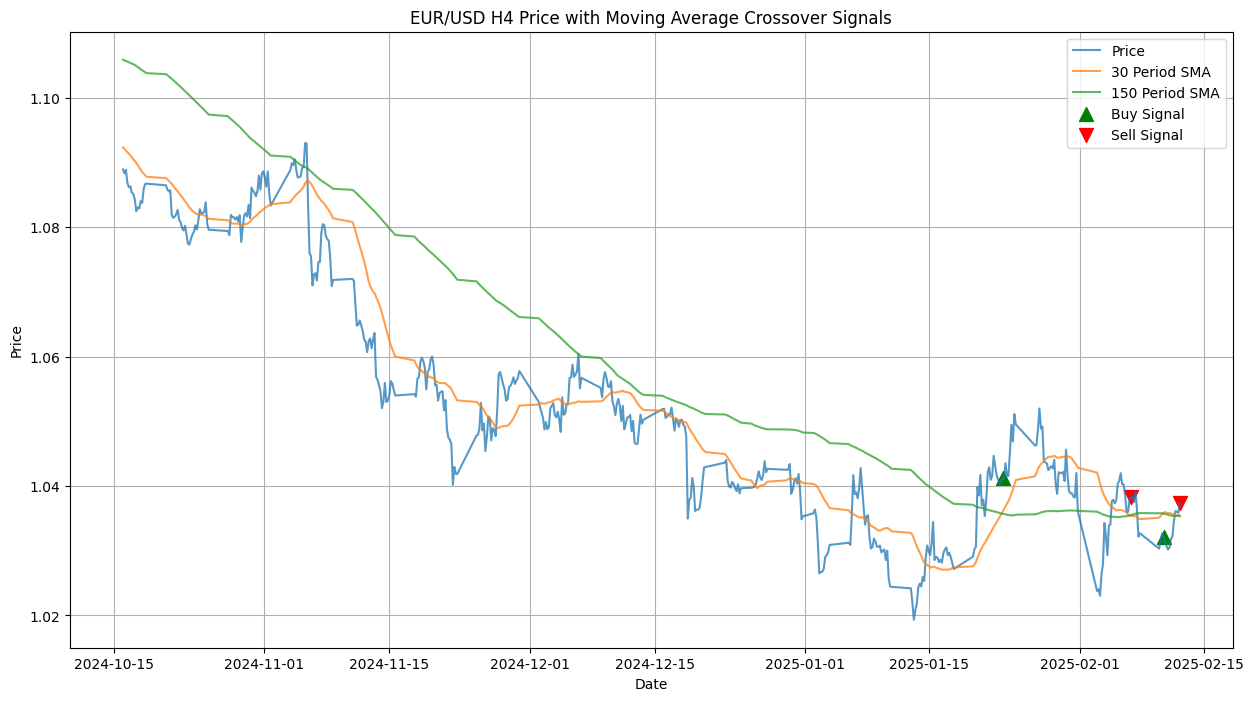


Crossover Signals:
                       close  signal
time                                
2015-03-30 01:00:00  1.08602       1
2015-03-31 09:00:00  1.07536      -1
2015-04-06 01:00:00  1.09774       1
2015-04-13 05:00:00  1.05566      -1
2015-04-28 01:00:00  1.08714       1
2015-05-25 17:00:00  1.09775      -1
2015-06-08 13:00:00  1.12330       1
2015-06-30 05:00:00  1.11414      -1
2015-07-31 09:00:00  1.10554       1
2015-08-03 13:00:00  1.09604      -1
2015-08-12 13:00:00  1.11752       1
2015-09-09 05:00:00  1.11939      -1
2015-09-11 13:00:00  1.13448       1
2015-09-23 09:00:00  1.11316      -1
2015-10-08 13:00:00  1.12823       1
2015-10-25 21:00:00  1.10211      -1
2015-12-07 14:00:00  1.08512       1
2016-01-06 02:00:00  1.07448      -1
2016-01-20 06:00:00  1.09235       1
2016-01-22 18:00:00  1.07983      -1
2016-02-01 14:00:00  1.08910       1
2016-02-25 10:00:00  1.10106      -1
2016-03-15 01:00:00  1.11073       1
2016-04-25 13:00:00  1.12661      -1
2016-05-02 01:00:0

In [51]:
import numpy as np

def identify_ma_crossovers(df, fast_col="SMA_30", slow_col="SMA_150"):
    """
    Identify MA crossover signals
    Returns DataFrame with signals: 1 for buy, -1 for sell, 0 for no signal
    """
    # Initialize signal column
    df["signal"] = 0

    # Create crossover signals
    df["signal"] = np.where(
        (df[fast_col] > df[slow_col])
        & (df[fast_col].shift(1) <= df[slow_col].shift(1)),
        1,  # Buy signal
        np.where(
            (df[fast_col] < df[slow_col])
            & (df[fast_col].shift(1) >= df[slow_col].shift(1)),
            -1,  # Sell signal
            0,  # No signal
        ),
    )

    return df


# Apply the crossover strategy
df_EURUSD_H4 = identify_ma_crossovers(df_EURUSD_H4)

# Plot with signals
plt.figure(figsize=(15, 8))

# Plot price and MAs
plt.plot(
    df_EURUSD_H4.index[-500:], df_EURUSD_H4["close"][-500:], label="Price", alpha=0.75
)
plt.plot(
    df_EURUSD_H4.index[-500:],
    df_EURUSD_H4["SMA_30"][-500:],
    label="30 Period SMA",
    alpha=0.75,
)
plt.plot(
    df_EURUSD_H4.index[-500:],
    df_EURUSD_H4["SMA_150"][-500:],
    label="150 Period SMA",
    alpha=0.75,
)

# Plot buy signals
plt.scatter(
    df_EURUSD_H4.index[-500:][df_EURUSD_H4["signal"][-500:] == 1],
    df_EURUSD_H4["close"][-500:][df_EURUSD_H4["signal"][-500:] == 1],
    marker="^",
    color="green",
    s=100,
    label="Buy Signal",
)

# Plot sell signals
plt.scatter(
    df_EURUSD_H4.index[-500:][df_EURUSD_H4["signal"][-500:] == -1],
    df_EURUSD_H4["close"][-500:][df_EURUSD_H4["signal"][-500:] == -1],
    marker="v",
    color="red",
    s=100,
    label="Sell Signal",
)

plt.title("EUR/USD H4 Price with Moving Average Crossover Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Print recent signals
signals = df_EURUSD_H4[df_EURUSD_H4["signal"] != 0]
print("\nCrossover Signals:")
print(signals[["close", "signal"]].to_string())